# Procesamiento de imágenes en paralelo con OpenCV

### Importar Librerias

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
from time import time
from functions import mostrar_imagen, dividir_imagen,mostrar_imagen_partes, combinar_partes,aplicar_BN

### Funciones y variables globales

In [2]:
# variable Global
N = 5; # hilos o procesos
tiempo_secuencial = 0
tiempo_paralelo_hilos = 0
tiempo_paralelo_datos = 0
tiempo_paralelo_tareas = 0
args = {
    "imagen": "gato.jpg" # Imagen
}

### Visualización de la imagen

<class 'numpy.ndarray'>


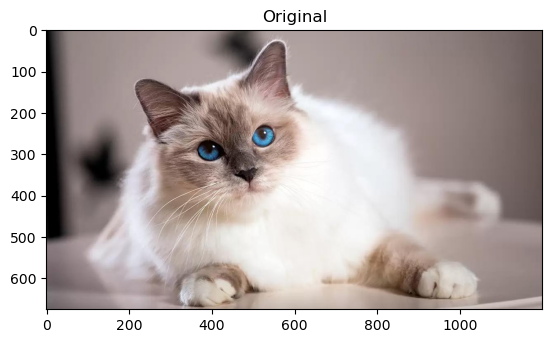

In [3]:
imagen = cv2.imread(args["imagen"]) # leemos la imagen de la variable global
imagen = cv2.cvtColor(imagen,cv2.COLOR_BGR2RGB)

mostrar_imagen("Original", imagen) # mostramos la imagen
print(type(imagen))

In [4]:
# Dimensiones de la imagen: h = alto w = ancho
(h, w) = imagen.shape[:2]

print("Altura de la imagen: %d"%(h))
print("Ancho de la imagen: %d"%(w))

Altura de la imagen: 675
Ancho de la imagen: 1200


# 1. Procesamiento Secuencial

0.001001119613647461 segundos


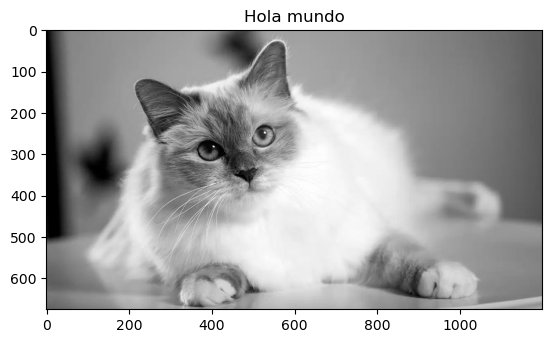

In [5]:
start = time()
imagenBNSE = aplicar_BN(imagen)
end = time()

mostrar_imagen("Hola mundo",imagenBNSE)
tiempo_secuencial = end - start
print(tiempo_secuencial, 'segundos')

# 2. Procesamiento Paralelo: Paralelismo de Tareas

In [6]:
import multiprocessing

0.788191556930542


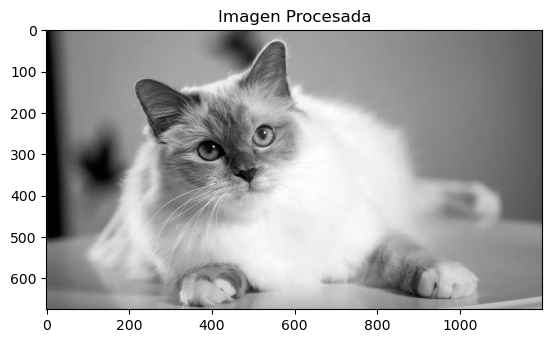

In [7]:
imagen_procesada = []
subconjuntos = []
#N = 10 # Número de procesos a utilizar

start = time()
if __name__ == "__main__":

    # Dividir la imagen en subconjuntos
    subconjuntos = dividir_imagen(imagen,w,h,N)

    with multiprocessing.Pool(processes=N) as pool:
        # Aplicar el filtro en paralelo a cada subconjunto
        resultados = pool.map(aplicar_BN, subconjuntos)

    # Combinar los resultados
    imagen_procesada = combinar_partes(resultados)
end = time()
tiempo_paralelo_tareas = end-start
print(tiempo_paralelo_tareas)
mostrar_imagen("Imagen Procesada", imagen_procesada)

In [ ]:
mostrar_imagen_partes(resultados,N)

# 3. Procesamiento Paralelo: Paralelismo de Datos

In [ ]:
# ejecutar en python
import cv2
import numpy as np
import multiprocessing
import time

def apply_filter(image_chunk, start_row, end_row, kernel, result, width):
    filtered_chunk = cv2.filter2D(image_chunk, -1, kernel)
    filtered_chunk_bytes = np.ndarray.tobytes(filtered_chunk)
    chunk_size = len(filtered_chunk_bytes) // width
    result[start_row * width * 1:end_row * width * 1] = filtered_chunk_bytes

def parallel_filter(image, kernel, num_processes=4):
    height, width = image.shape
    chunk_size = height // num_processes
    processes = []
    result = multiprocessing.RawArray('B', height * width * 1)  # Shared array of unsigned 8-bit integers

    for i in range(num_processes):
        start_row = i * chunk_size
        end_row = start_row + chunk_size if i < num_processes - 1 else height
        image_chunk = image[start_row:end_row]
        process = multiprocessing.Process(target=apply_filter, args=(image_chunk, start_row, end_row, kernel, result, width))
        processes.append(process)
        process.start()

    for process in processes:
        process.join()

    # Convert the shared array back to numpy array
    filtered_image = np.frombuffer(result, dtype=np.uint8)
    filtered_image = filtered_image.reshape((height, width))

    return filtered_image

start = time()


if __name__ == "__main__":
    input_image_path = "gato.jpg"

    # Intenta cargar la imagen en escala de grises
    input_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)
    if input_image is None:
        print("Error: No se pudo cargar la imagen. Verifica la ruta del archivo.")
    else:
        # Define el kernel para convertir la imagen a escala de grises
        kernel = np.array([[0.2989, 0.5870, 0.1140]])  # Coeficientes para la conversión a escala de grises

        # Calcula el tiempo de inicio
        start_time = time.time()

        # Aplica el filtro de forma paralela
        filtered_image = parallel_filter(input_image, kernel, num_processes=4)

        # Calcula el tiempo de finalización
        end_time = time.time()

        # Guarda la imagen de salida en blanco y negro
        output_image_path = r"DatosGato.jpg"
        cv2.imwrite(output_image_path, filtered_image)

        print(f"Procesamiento paralelo de la imagen completado. Tiempo de ejecución: {end_time - start_time} segundos. Imagen de salida en blanco y negro guardada como {output_image_path}")
        
end = time()

tiempo_paralelo_datos =end - start
print(tiempo_paralelo_datos)

In [11]:
tiempo_paralelo_datos =0.61
print(tiempo_paralelo_datos)

0.61


# 4. Procesamiento Paralelo: Paralelismo con hilos

In [ ]:
#arr = dividir_imagen(imagen,w,h,N)
# mostrar_imagen_partes(arr,N)

In [8]:
import concurrent.futures

0.004001617431640625 segundos


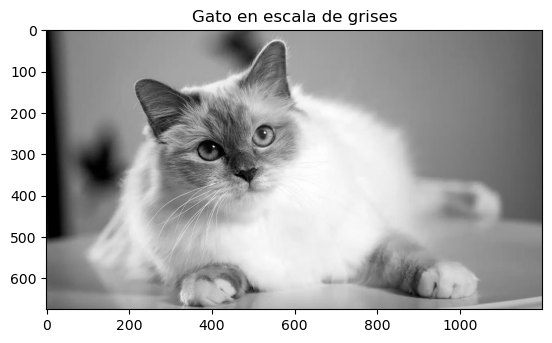

In [9]:
result = [] # partes de la imagen

inicio = time()
imagen_partes = dividir_imagen(imagen,w,h,N)
with concurrent.futures.ThreadPoolExecutor(max_workers=N) as executor: # N hilos
    resultados = executor.map(aplicar_BN, imagen_partes)

for resultado in resultados:
    result.append(resultado)

imagenBN = combinar_partes(result) # juntamos las partes en escala de grises

fin = time()

mostrar_imagen("Gato en escala de grises",imagenBN)

tiempo_paralelo_hilos = fin - inicio
print(tiempo_paralelo_hilos, 'segundos')

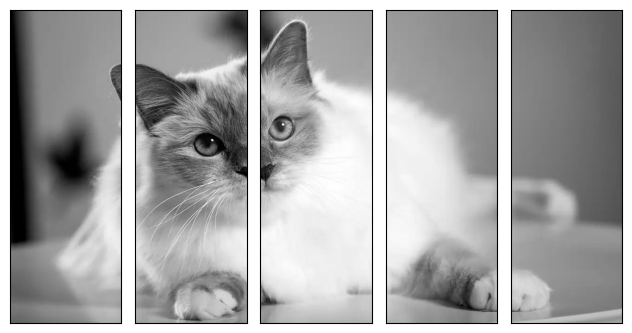

In [10]:
mostrar_imagen_partes(result,N)

# 5. Comparación de tiempos

In [12]:
print("Secuencial: ",tiempo_secuencial)
print("Tarea: ",tiempo_paralelo_tareas)
print("Datos: ",tiempo_paralelo_datos)
print("Hilos: ",tiempo_paralelo_hilos)

Secuencial:  0.001001119613647461
Tarea:  0.788191556930542
Datos:  0.61
Hilos:  0.004001617431640625
